<h1>Chapter 3 - Looking Inside Transformer LLMs</h1>
<i>An extensive look into the transformer architecture of generative LLMs</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter03/Chapter%203%20-%20Looking%20Inside%20LLMs.ipynb)

---

This notebook is for Chapter 3 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


现在我们已经有了标记化和嵌入的感觉，我们准备更深入地研究语言模型，看看它是如何工作的。
在本章中，我们将看看Transformer语言模型是如何工作的。我们的重点将放在文本生成模型上。

In [ ]:
# %%capture
#!pip install transformers>=4.41.2 accelerate>=0.31.0

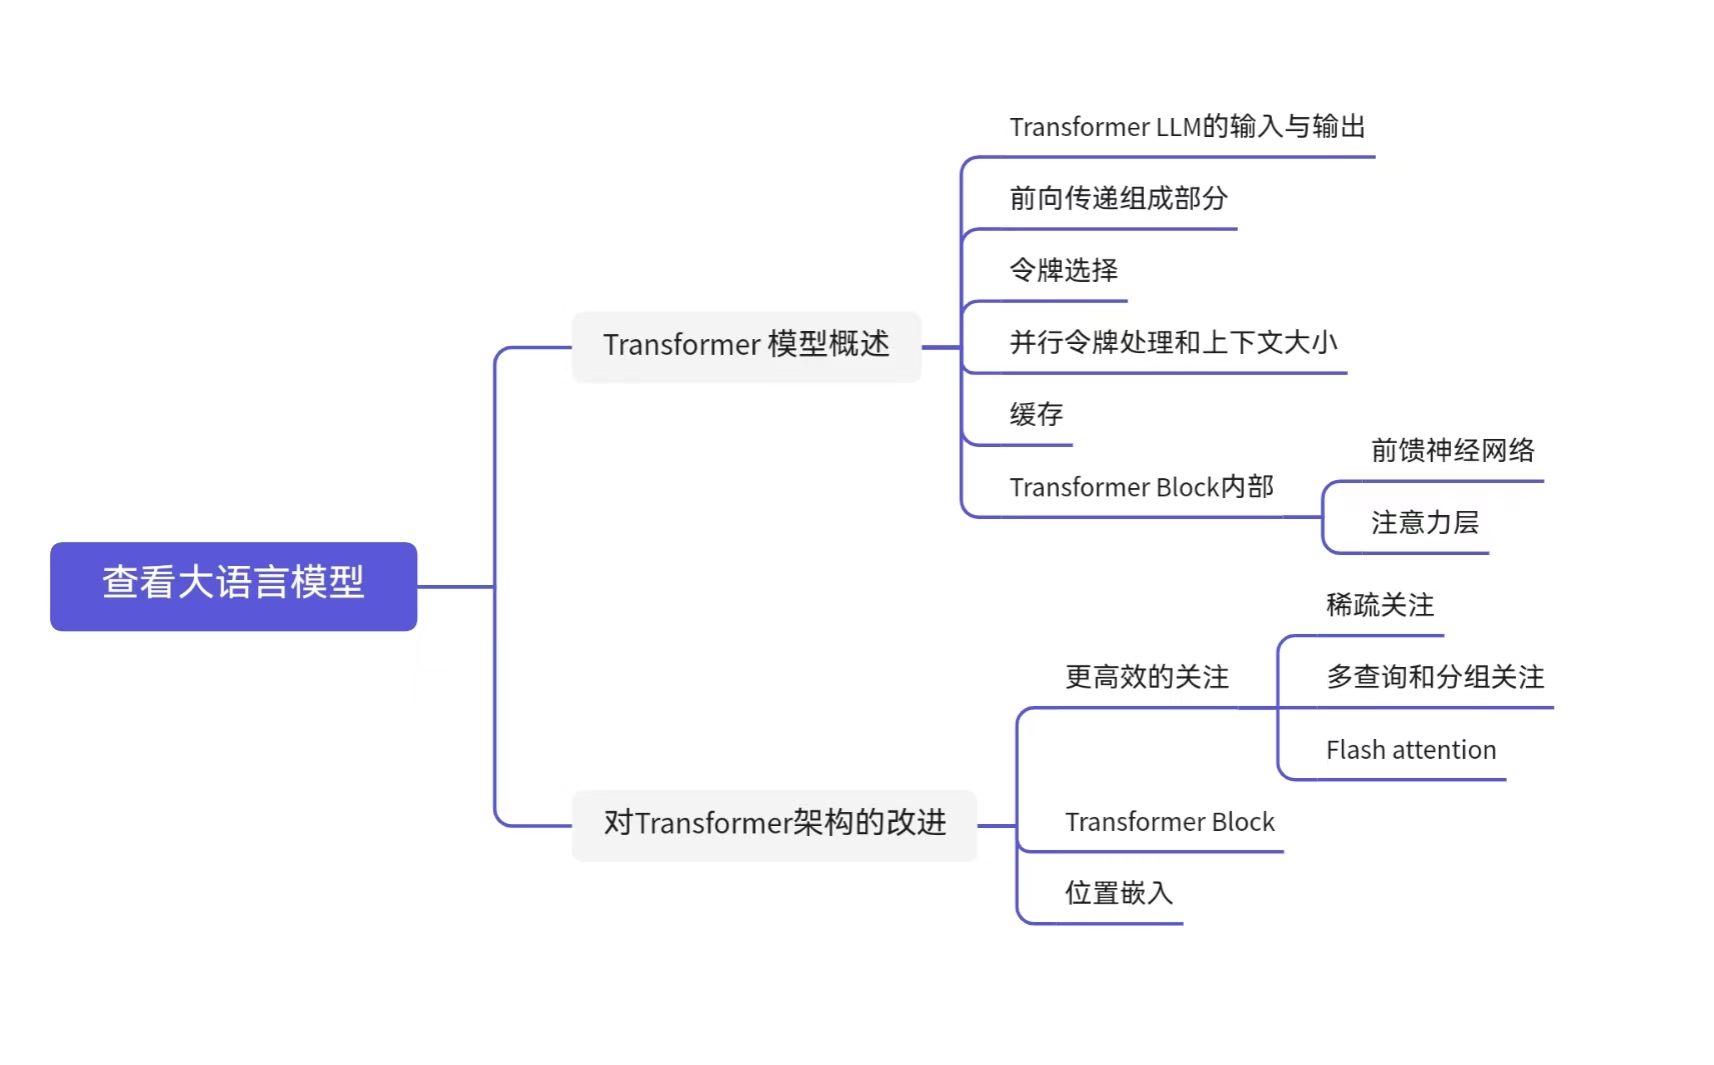

# Loading the LLM

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# Create a pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=50,
    do_sample=False,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

# transformer模型概述

## The Inputs and Outputs of a Trained Transformer LLM


理解Transformer LLM最常见的描述是将其视为一个软件系统，它接收文本并生成文本作为响应。一旦在足够大的高质量数据集上训练了足够大的文本输入文本输出模型，它就能够生成令人印象深刻且有用的输出。

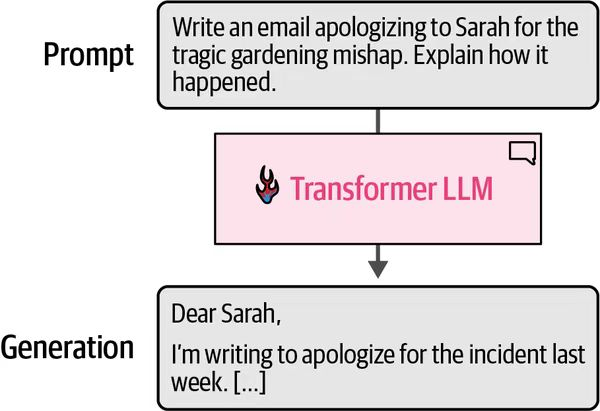

该模型不会在一次操作中全部生成文本;它实际上是一次生成一个令牌。

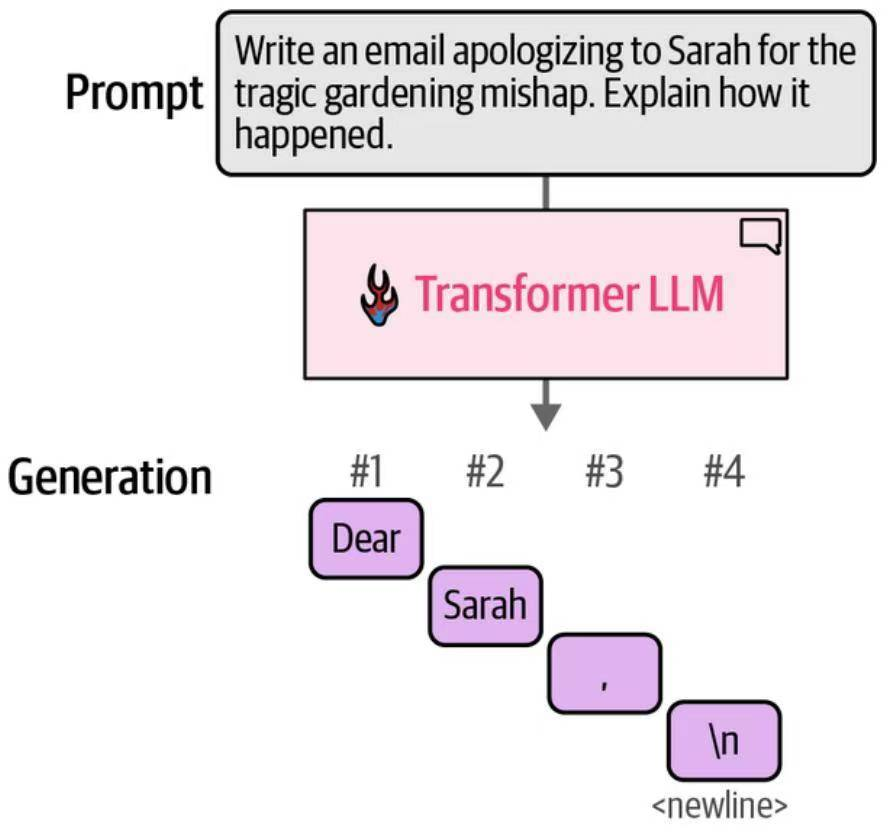

在每个令牌生成之后，我们通过将输出令牌附加到输入提示符的末尾来调整输入提示符以用于下一个生成步骤。

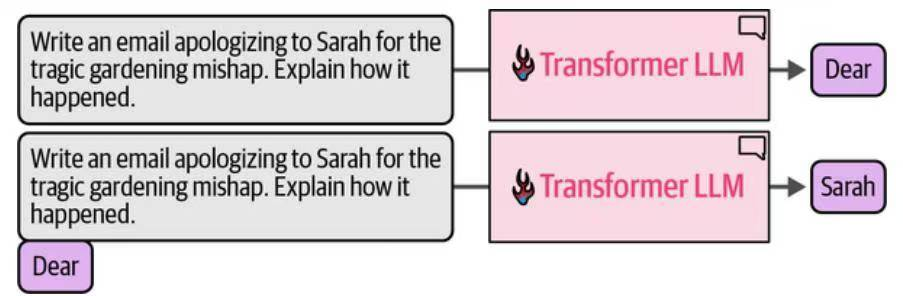

在机器学习中，有一个特定的词用来描述那些消耗其早期预测以进行后期预测的模型(例如，模型的第一个生成的令牌用于生成第二个令牌)。它们被称为自回归模型。这通常用于区分文本生成模型和BERT等文本表示模型，后者不是自回归的。

In [ ]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

output = generator(prompt)

print(output[0]['generated_text'])




Solution 1:

Subject: My Sincere Apologies for the Gardening Mishap


Dear Sarah,


I hope this message finds you well. I am writing to express my deep


我们可以看到模型开始从主题开始写邮件。它突然停止了，因为它达到了我们通过设置建立的令牌限制 max_new_tokens 到50个token。如果我们增加，它将持续到结束电子邮件。 

## The Components of the Forward Pass

除了循环之外，两个关键的内部组件是标记器和语言建模头(LM head)。

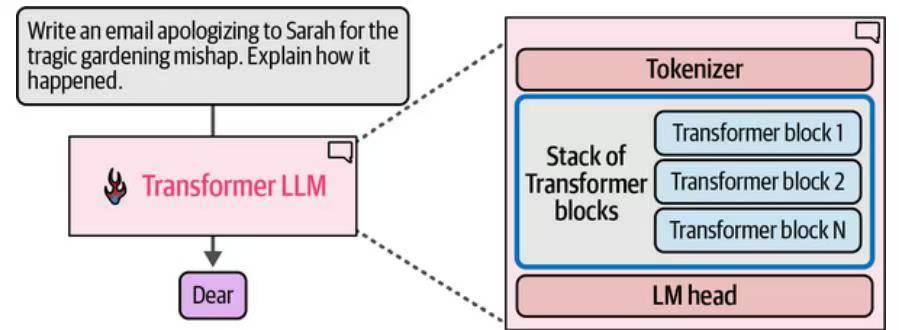

token化器之后是神经网络:一堆Transformer块，完成所有的处理。该堆栈之后是LM head，它将堆栈的输出转换为最有可能的下一个令牌是什么的概率分数。

回想一下第2章，标记器包含一个标记表——标记器的词汇表。该模型具有与词汇表中的每个标记相关联的向量表示(标记嵌入)。图3-5显示了一个词汇表为50,000个标记的模型的词汇表和关联的标记嵌入。

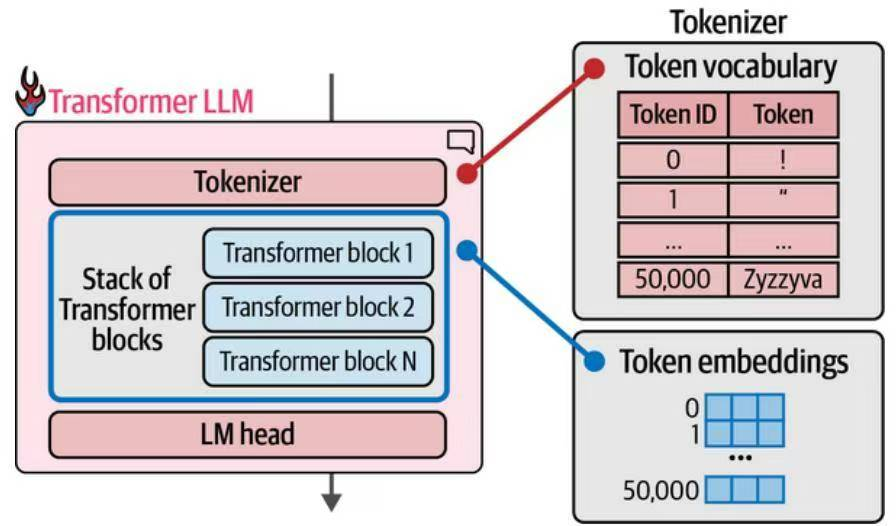

计算的流程遵循箭头从上到下的方向。对于每个生成的令牌，该流程依次流过堆栈中的每个Transformer块一次，然后流向LM头部，最终输出下一个令牌的概率分布，如图3-6所示。

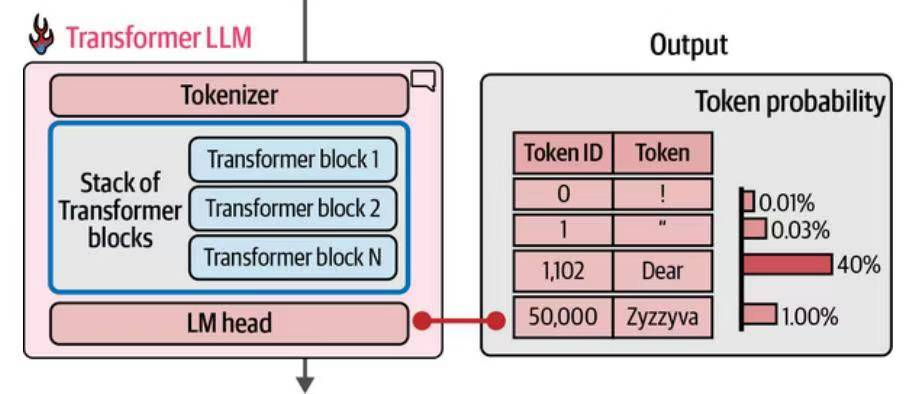

LM头本身就是一个简单的神经网络层。它是多个可能的“头”之一，可以附加到一堆Transformer块上，以构建不同类型的系统。其他种类的Transformer头包括序列分类头和令牌分类头。

我们可以通过简单地打印出模型变量来显示层的顺序。

In [ ]:
print(model)

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

看这个结构，我们可以注意到以下几个亮点:  
- 这向我们展示了模型的各种嵌套层。模型的大部分都被标记了的模型，后面是 lm_head. 
- 在 Phi3Model 模型，我们看到嵌入矩阵 embed_tokens以及它的维度。它有32064个令牌，每个令牌的向量大小为3072。 
- 暂时跳过dropout层，我们可以看到下一个主要组件是Transformer解码器层的堆栈。它包含32个类型块 Phi3DecoderLayer. 
- 这些Transformer块中的每一个都包括一个注意层和一个前馈神经网络(也称为an) 中长期规划 或多层感知机)。我们将在本章后面更详细地介绍这些。  
- 最后，我们看到 lm_head 取一个大小为3072的向量，输出一个与模型知道的令牌数量相等的向量。该输出是每个标记的概率得分，它可以帮助我们选择输出标记。 

## Choosing a single token from the probability distribution (sampling / decoding)

在处理结束时，模型的输出是词汇表中每个标记的概率得分。从概率分布中选择单个令牌的方法称为解码策略。

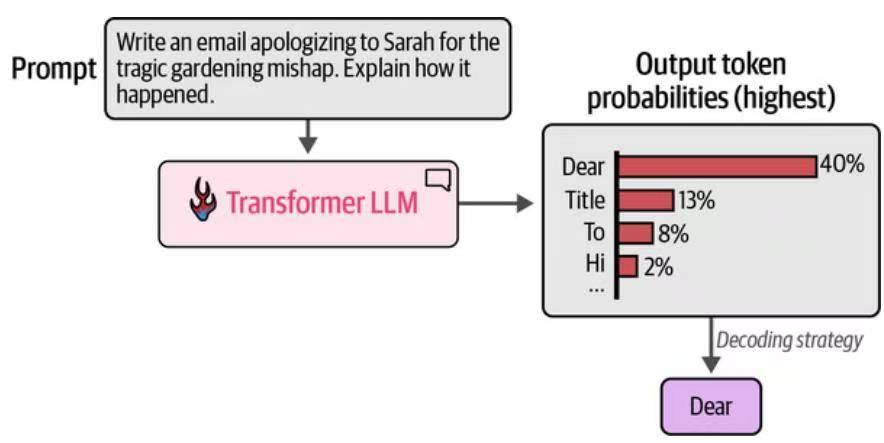

最简单的解码策略是总是选择概率得分最高的令牌。在实践中，对于大多数用例来说，这往往不会产生最佳输出。更好的方法是添加一些随机性，有时选择概率第二或第三高的令牌。这里的想法基本上是根据概率得分从概率分布中抽样。

对于图3-7中的例子来说，这意味着如果令牌“Dear”有40%的概率成为下一个令牌，那么它就有40%的机会被选中(而不是贪婪搜索，贪婪搜索会因为得分最高而直接选择它)。所以用这种方法，所有其他的token都有机会根据分数被选中。 
每次选择得分最高的令牌被称为贪婪解码。如果你在LLM中设置温度参数为零，就会发生这种情况。我们将在第6章中介绍温度的概念。 

In [ ]:
prompt = "The capital of France is"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Tokenize the input prompt
input_ids = input_ids.to("cuda")

# Get the output of the model before the lm_head
model_output = model.model(input_ids)

# Get the output of the lm_head
lm_head_output = model.lm_head(model_output[0])

In [ ]:
token_id = lm_head_output[0,-1].argmax(-1)
tokenizer.decode(token_id)

'Paris'

## Parallel Token Prossing and Context Size

transformer最引人注目的特点之一是，在语言处理方面，它们比以前的神经网络架构更适合并行计算。

从上一章我们知道，标记器会将文本分解成标记。然后，这些输入令牌中的每一个都流经自己的计算路径。

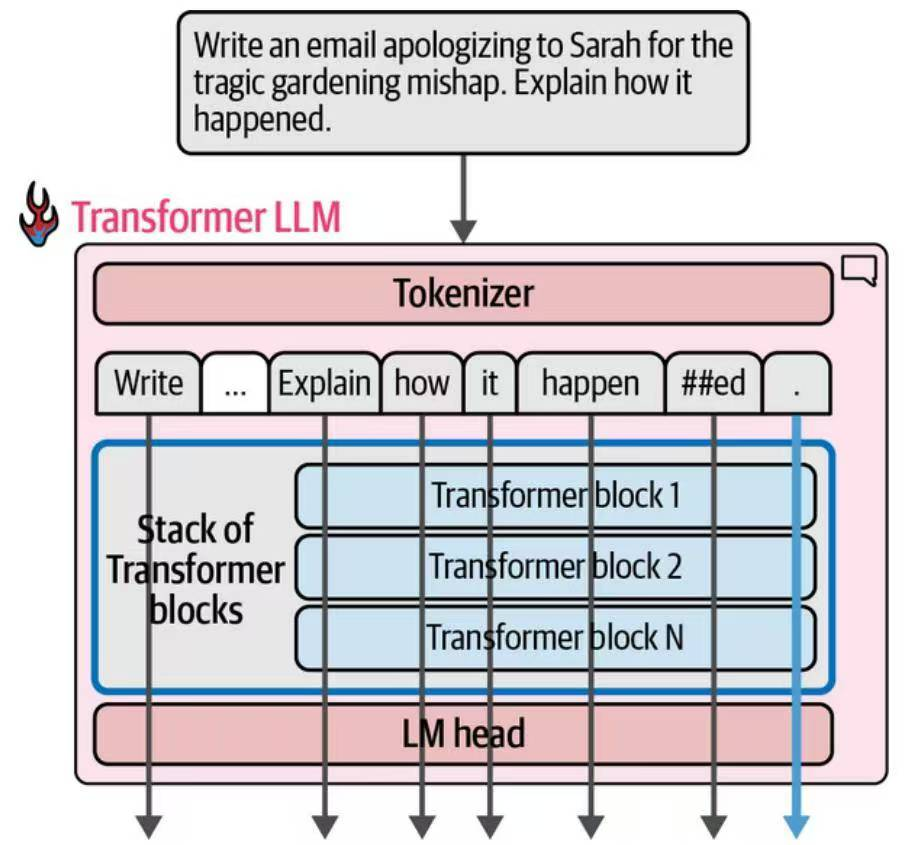

transformer模型对一次可以处理的令牌数量有一个限制。这个限制被称为模型的上下文长度。

每个令牌流都以一个输入向量开始(嵌入向量和一些位置信息)。在流的最后，另一个向量作为模型处理的结果出现。

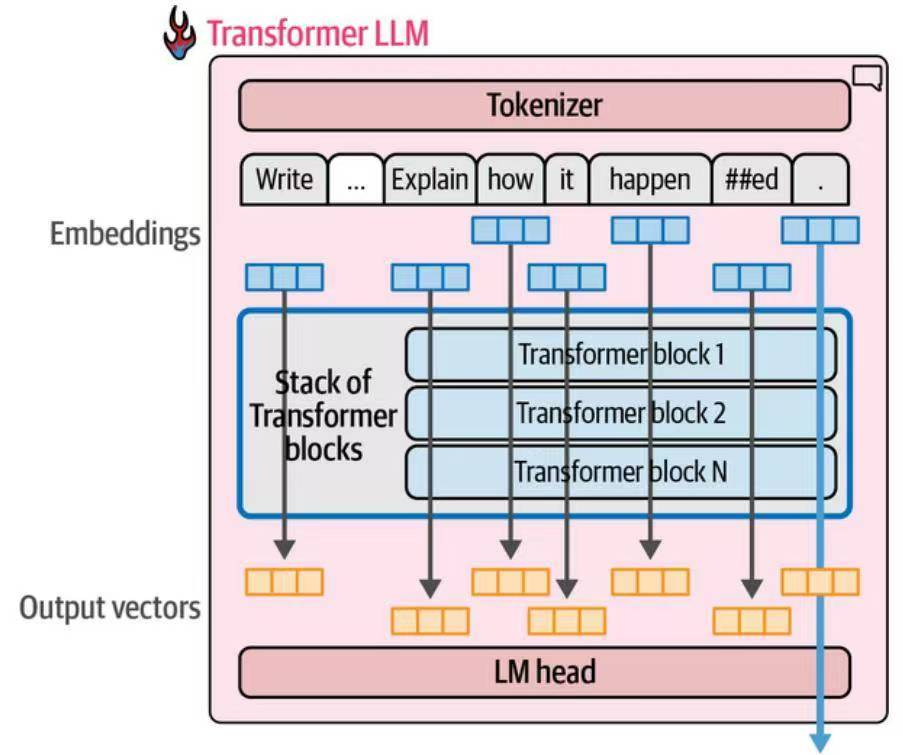

对于文本生成，只使用最后一个流的输出结果来预测下一个令牌。该输出向量是LM头部的唯一输入，因为它计算下一个令牌的概率。

你可能想知道，如果我们放弃除最后一个令牌以外的所有输出，为什么我们要经历计算所有令牌流的麻烦。答案是，之前的流的计算是必需的，并用于计算最后的流。是的，我们没有使用它们的最终输出向量，但我们在Transformer块的注意力机制中使用了更早的输出(在每个Transformer块中)。

回忆一下 lm_head的形状为[1,6,32064]。这是因为它的输入是形状为[1,6,3072]的，它是一批一个输入字符串，包含6个令牌，每个令牌由一个大小为3,072的向量表示，对应于Transformer块堆栈后的输出向量。 我们可以通过打印命令来访问这些矩阵并查看它们的维度:

In [ ]:
model_output[0].shape

torch.Size([1, 6, 3072])

In [ ]:
lm_head_output.shape

torch.Size([1, 6, 32064])

## Speeding up generation by caching keys and values


回想一下，在生成第二个令牌时，我们只需将输出令牌附加到输入上，并通过模型进行另一次前向传递。如果我们赋予模型缓存先前计算结果的能力(特别是注意机制中的某些特定向量)，我们就不再需要重复先前流的计算。这一次只需要计算最后一个流。这是一种称为键和值(kv)缓存的优化技术，它提供了生成过程的显着加速。键和值是注意力机制的一些核心组成部分，我们将在本章后面看到。

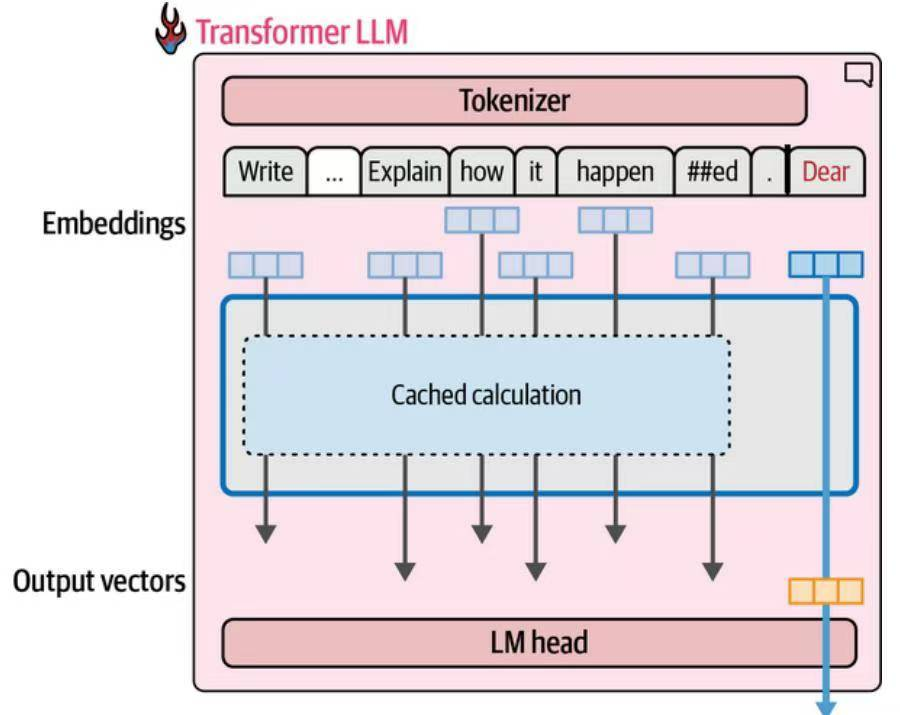

图3-10显示了在生成第二个令牌时，只有一个处理流是活跃的，因为我们缓存了前面流的结果。

在Husing Face Transformers中，缓存是默认启用的。我们可以通过设置 use_cache = False。我们可以通过请求长时间的生成，以及在有缓存和没有缓存的情况下计时来看到速度上的差异。

In [ ]:
prompt = "Write a very long email apologizing to Sarah for the tragic gardening mishap. Explain how it happened."

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
input_ids = input_ids.to("cuda")

In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=True
)

6.66 s ± 2.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit -n 1
# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=100,
  use_cache=False
)

21.9 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Inside the Transformer Block

Transformer llm由一系列Transformer模块组成(在原始Transformer论文中通常为6个，而在许多大型llm中则超过100个)。每个块处理其输入，然后将其处理结果传递给下一个块。

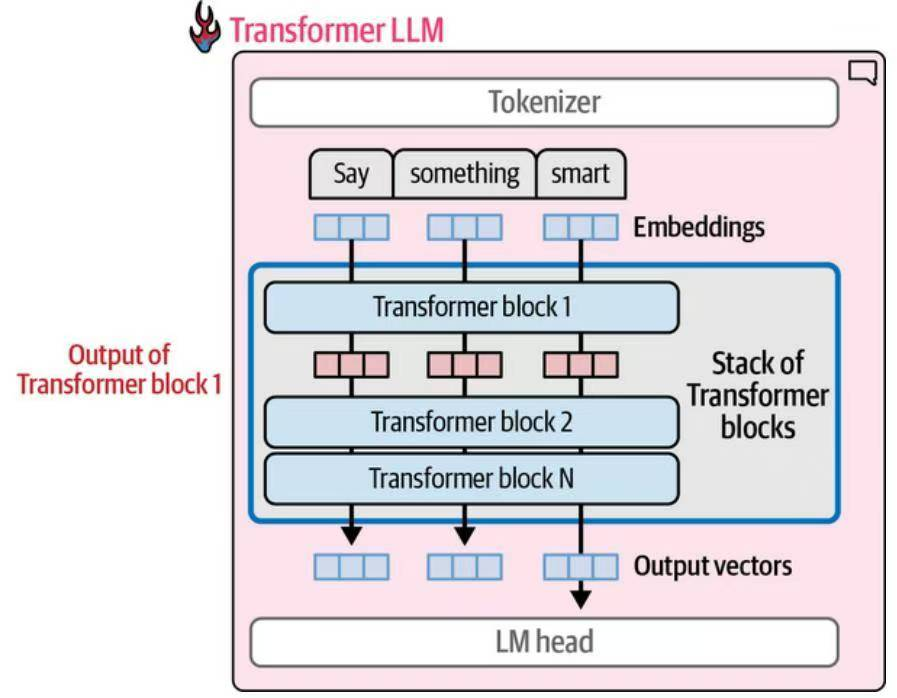

一个Transformer块由两个连续的组件组成:   
- 注意层主要负责整合来自其他输入令牌和位置的相关信息  
- 前馈层容纳了模型的大部分处理能力 

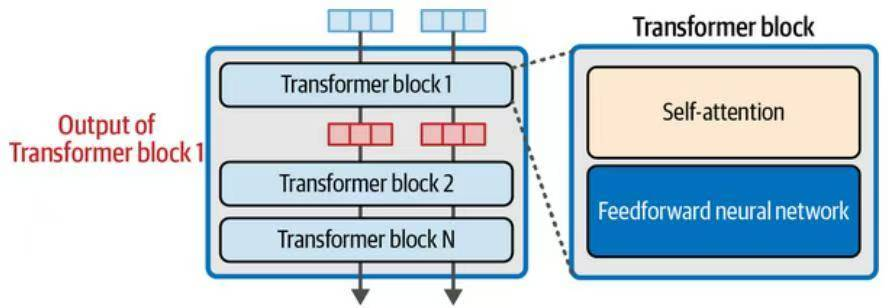

### The feedforword neural network at a glance

给出前馈神经网络直觉的一个简单例子是，如果我们将简单的输入“The Shawshank”传递给语言模型，期望它将生成“Redemption”作为最可能的下一个单词

前馈神经网络是这些信息的来源，如图3-13所示。当模型被成功地训练成模拟大量文本档案(其中包括许多提到“肖申克的救赎”)时，它学习并存储了使其成功完成这项任务的信息(和行为)。

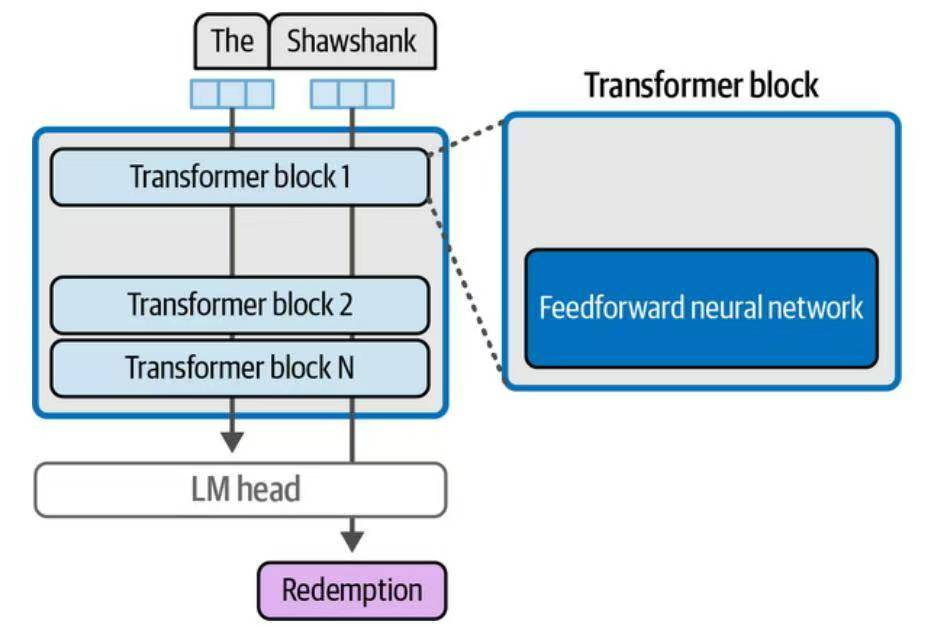

对于一个成功训练的LLM来说，它需要记忆大量的信息。但它并不是一个简单的大型数据库。记忆只是令人印象深刻的文本生成配方中的一个成分。该模型能够使用相同的机制在数据点和更复杂的模式之间进行插值，从而能够进行泛化——这意味着它可以很好地处理过去没有见过的输入，并且不在其训练数据集中。

### The attention layer at a glance

注意是一种帮助模型在处理特定令牌时整合上下文的机制。想想下面的提示词:

“The dog chased the squirrel because it”

在经过训练的Transformer LLM中，注意力机制会做出这样的决定。注意力将来自上下文的信息添加到“it”令牌的表示中。为了让模型预测“it”之后的内容，它需要知道“it”指的是什么。它指的是狗还是松鼠?

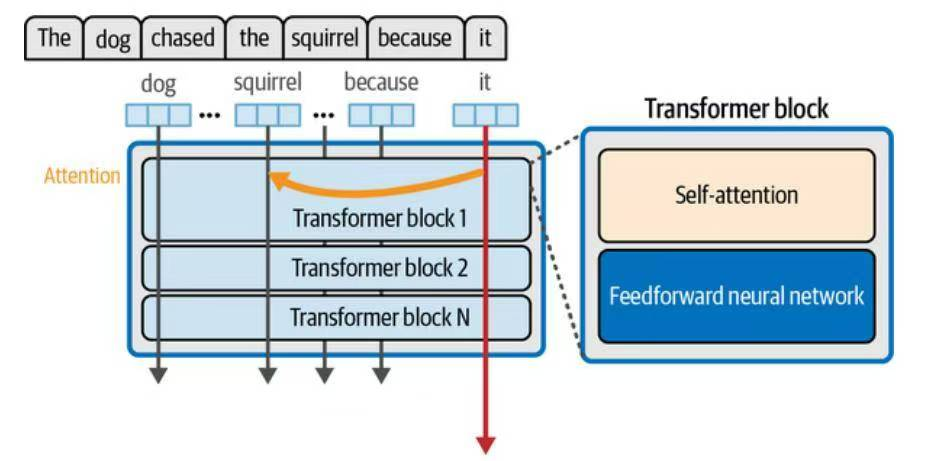

这个模型是基于从训练数据集中看到和学习到的模式来做的。也许前面的句子也提供了更多的线索，比如，将狗称为“她”，从而清楚地表明“它”指的是松鼠。

### Attention is all your need

注意机制值得深入研究。该机制最精简的版本如图3-15所示。它显示了进入注意层的多个令牌位置;最后一个是当前正在处理的那个(粉色箭头)。注意机制对该位置的输入向量进行操作。它将上下文中的相关信息整合到它产生的向量中，作为该位置的输出。

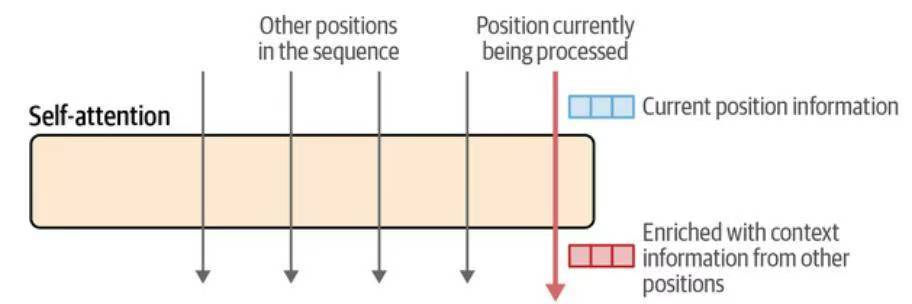

注意机制涉及两个主要步骤:          
- 一种对之前的每个输入标记与当前正在处理的标记的相关性进行评分的方法(在粉色箭头中)。  
- 使用这些分数，我们将来自不同位置的信息组合成一个单一的输出向量。

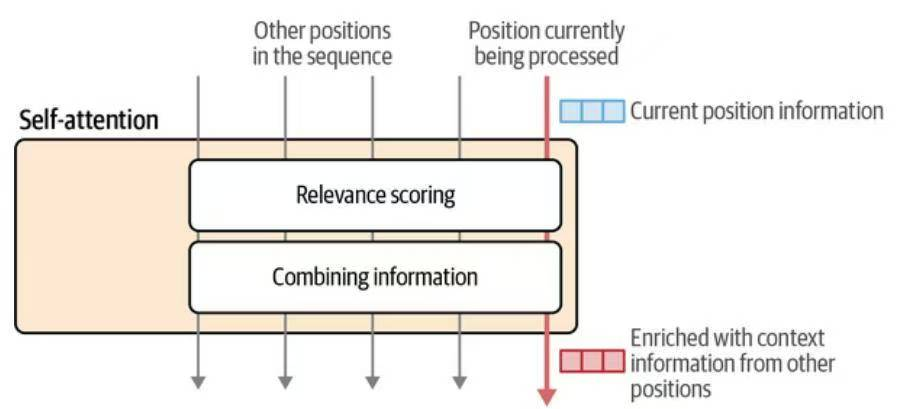

为了赋予Transformer更广泛的注意力能力，注意力机制被复制并并行执行多次。这些注意力的每一次并行应用都被进行到一个注意力头中。这增加了模型对输入序列中需要同时关注不同模式的复杂模式进行建模的能力。

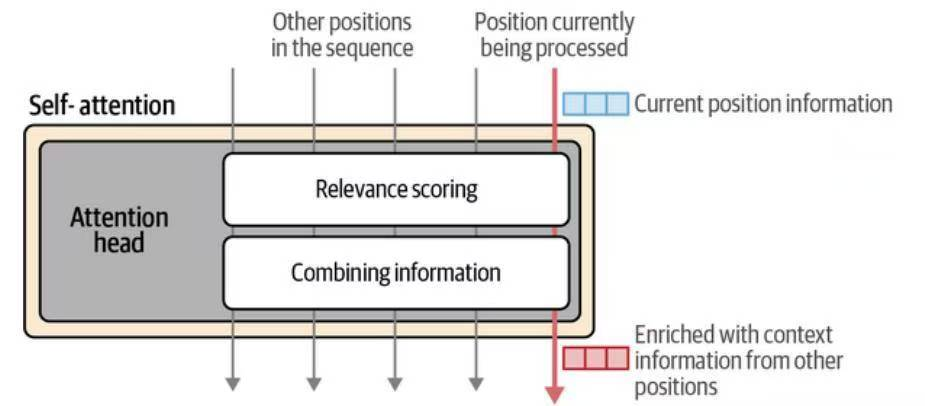

### How attention is calculated

为了简单起见，让我们只看一个注意头，因为其他的头有相同的计算，但有各自的投影矩阵。

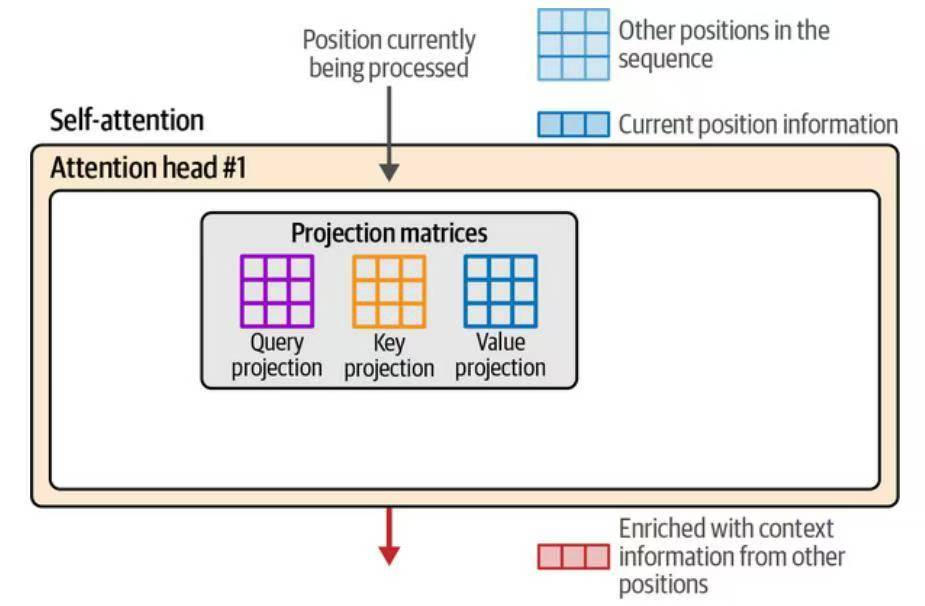

注意首先将输入乘以投影矩阵，以创建三个新的矩阵。它们被称为查询(Q)矩阵、键(K)矩阵和值(V)矩阵。这些矩阵包含投射到三个不同空间的输入令牌的信息。

这些信息有助于执行注意的两个步骤:
- 相关性得分  
- 组合信息

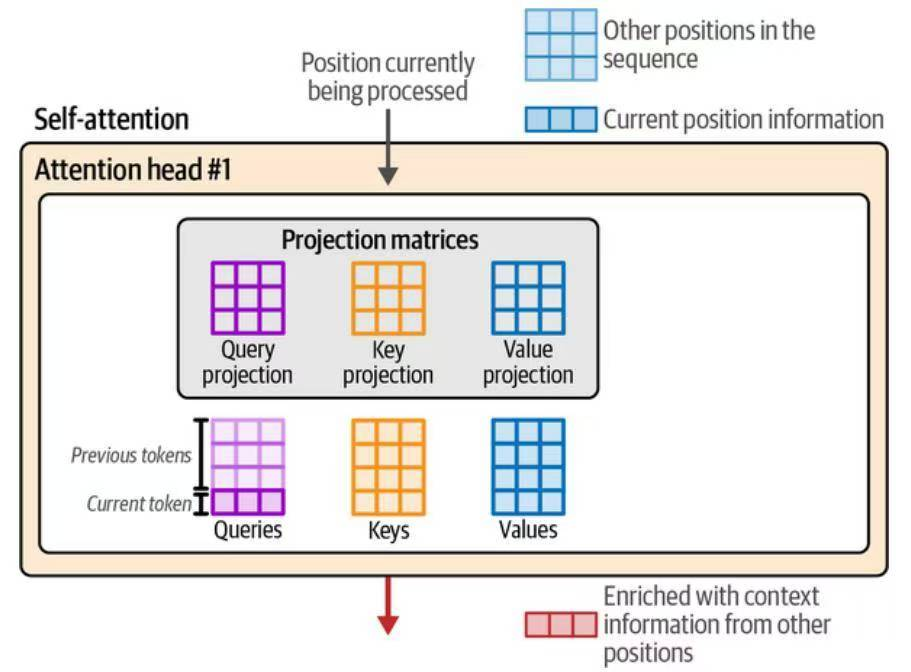

图3-19显示了这三个新矩阵，以及所有三个矩阵的最下面一行是如何与当前位置关联的，而它上面的行是如何与之前的位置关联的。 

### Self-attention:Relevance scoring

在生成式Transformer中，我们一次生成一个令牌。这意味着我们一次处理一个位置。所以这里的注意机制只关注这一个位置，以及如何将其他位置的信息拉进来通知这个位置。 

注意力的相关性评分步骤是通过将当前位置的查询向量与键矩阵相乘来进行的。这将产生一个分数，说明每个先前的标记的相关性。通过softmax操作传递该值将这些分数标准化，因此它们的总和为1。图3-20显示了由此计算得出的相关性评分。

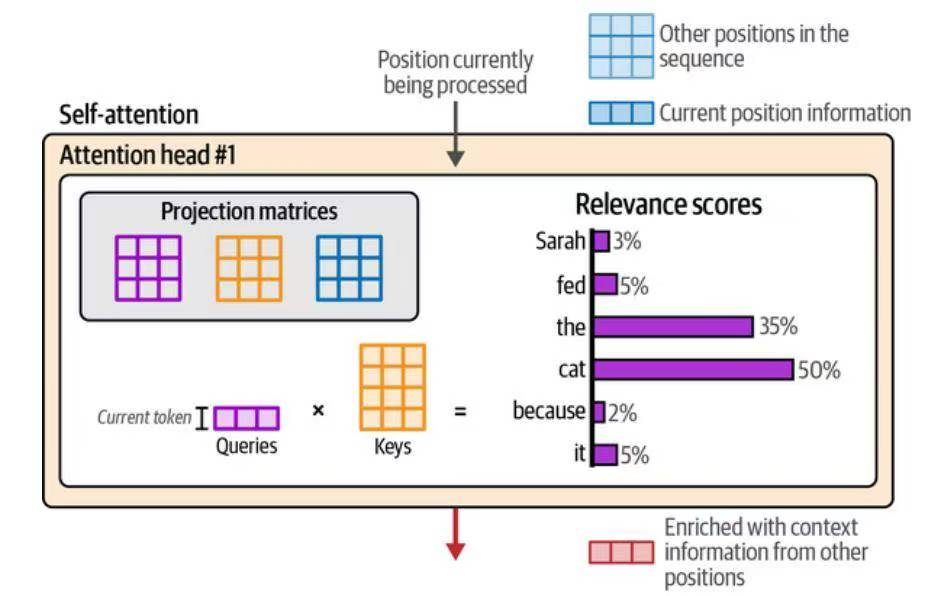

### Self-attention:Combining information

现在我们有了相关性分数，我们将与每个标记相关联的值向量乘以该标记的分数。将这些结果向量加起来就产生了这个注意力步骤的输出。

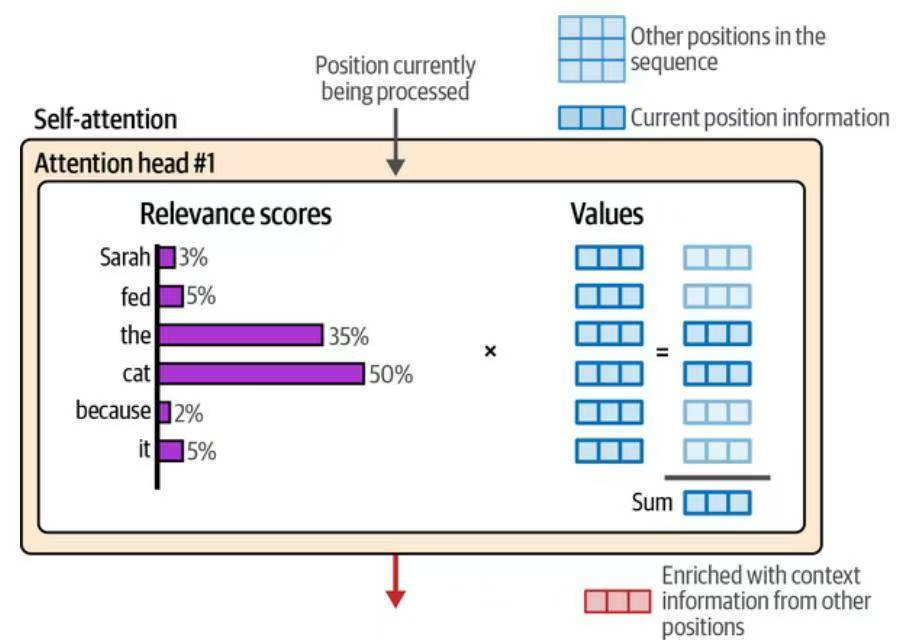

# Recent Improvements to the Transformer Architecture

自Transformer架构发布以来，已经做了很多工作来改进它并创建更好的模型。这涵盖了在更大的数据集上进行训练，并针对训练过程和学习率进行了优化，但它也扩展到了体系结构本身。

## More Efficient Attention

最受研究界关注的领域是Transformer的关注层。这是因为注意力计算是整个过程中计算成本最高的部分。 

## Local/sparse attention

稀疏注意力限制了模型可以关注的先前令牌的上下文

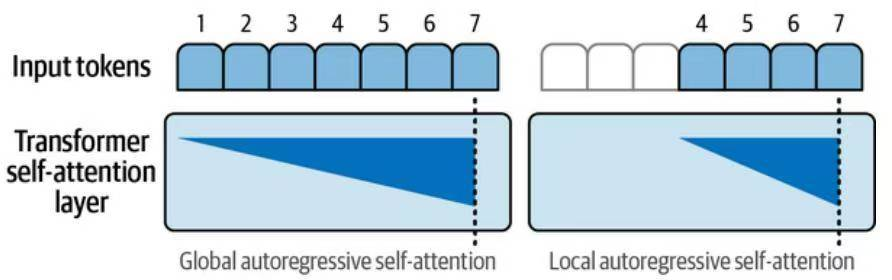

一个包含这种机制的模型是GPT-3。但它并不是对所有的Transformer区块都使用这种机制——如果模型只能看到少量以前的token，生成的质量会大大降低。GPT-3架构交织了全注意力和高效注意力Transformer模块。因此Transformer模块在充分关注和稀疏关注之间交替进行。

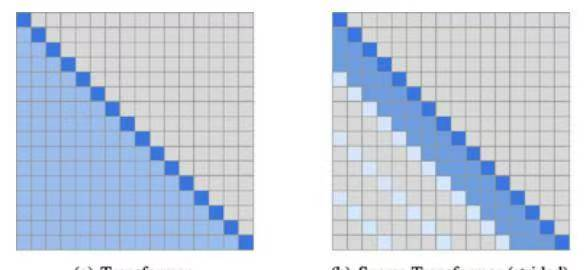

图3-23展示了不同的注意力机制是如何工作的。

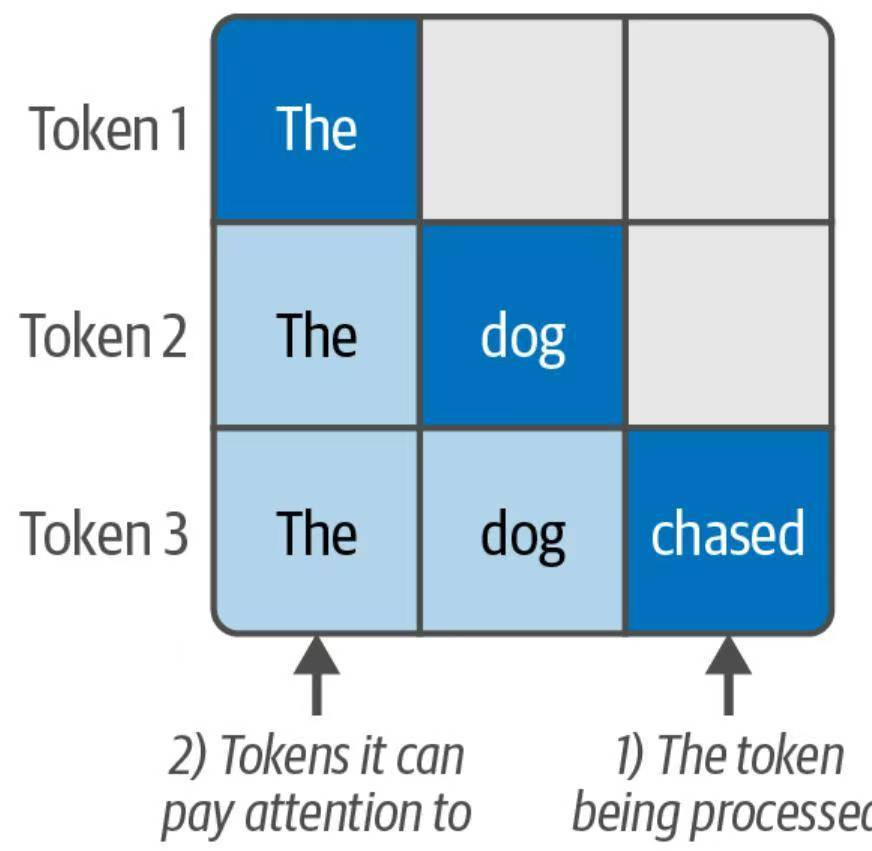

该图还显示了解码器Transformer块(它构成了大多数文本生成模型)的自回归性质;它们只能关注之前的令牌。与此形成对比的是BERT，它可以同时关注双方(因此BERT中的B代表双向)。

### Multi-query and grouped-query attention

最近对Transformer进行的一种更有效的注意力调整是分组查询注意力。Llama 2和3等模型使用了分组查询注意力。

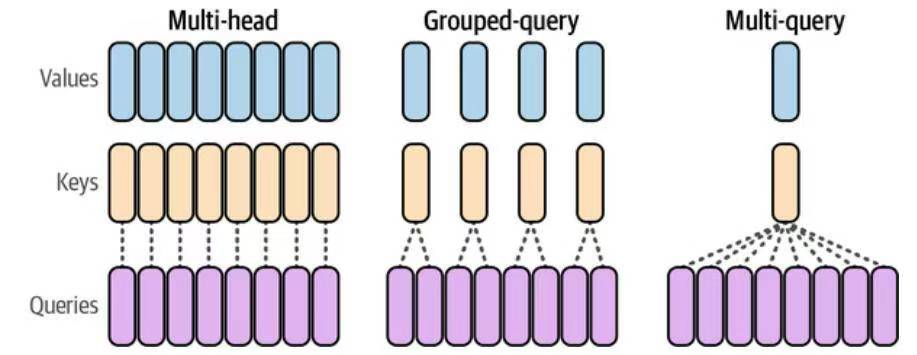

这些方法通过减少所涉及的矩阵的多少来提高较大模型的推理可扩展性。

传统的多头注意力实质上是将输入分成多个头部，并为每个头部独立计算注意力。Q、K和V都根据每个head进行不同的转换，这在头数量较多时可能会计算密集。

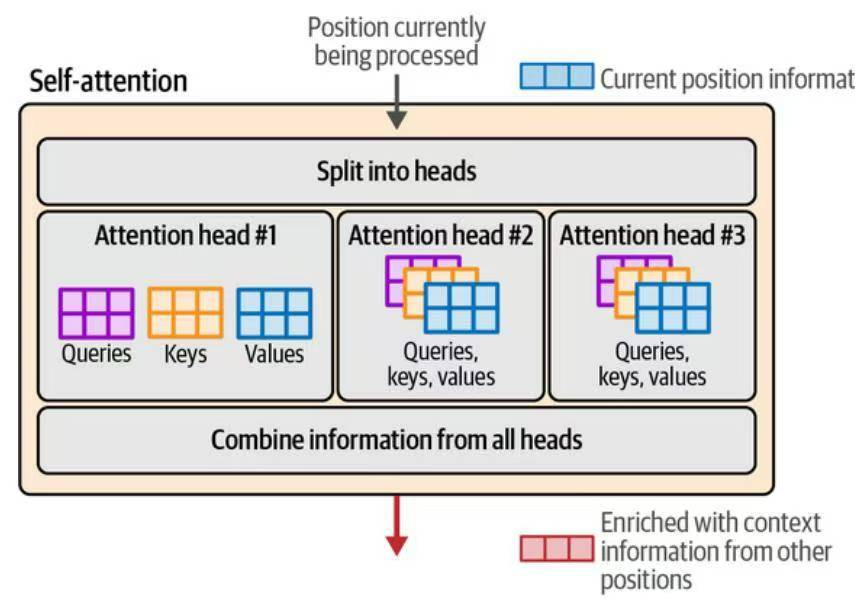

多查询注意优化这一点的方式是在所有头之间共享键和值矩阵。所以每个头唯一不同的矩阵就是Q矩阵。

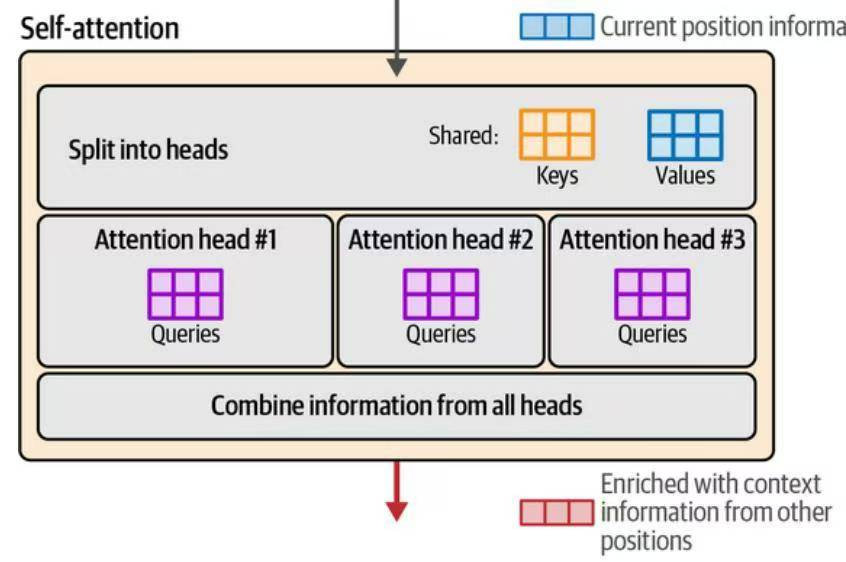

然而，随着模型规模的增长，这种优化可能会带来太大的惩罚，我们可以使用更多的内存来提高模型的质量。这就是分组查询关注的用兵之处。它不是将键和值矩阵的数量削减为每个一个，而是允许我们使用更多(但少于头的数量)。

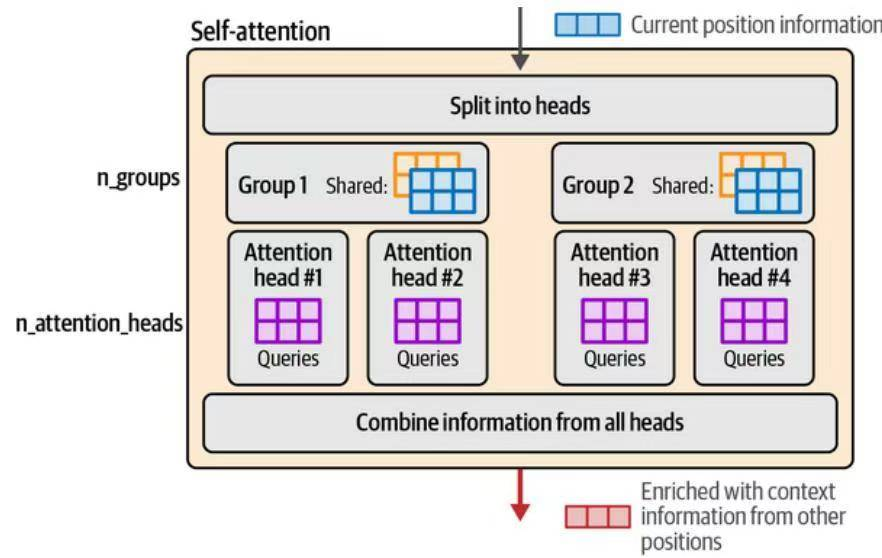

### Flash Attention

Flash Attention是一种流行的方法和实现，它为gpu上Transformer llm的训练和推理提供了显著的加速。它通过优化在GPU的共享内存(SRAM)和高带宽内存(HBM)之间加载和移动的值来加快注意力计算。

## The Transformer Block

Transformer块的两个主要组成部分是注意层和前馈神经网络。

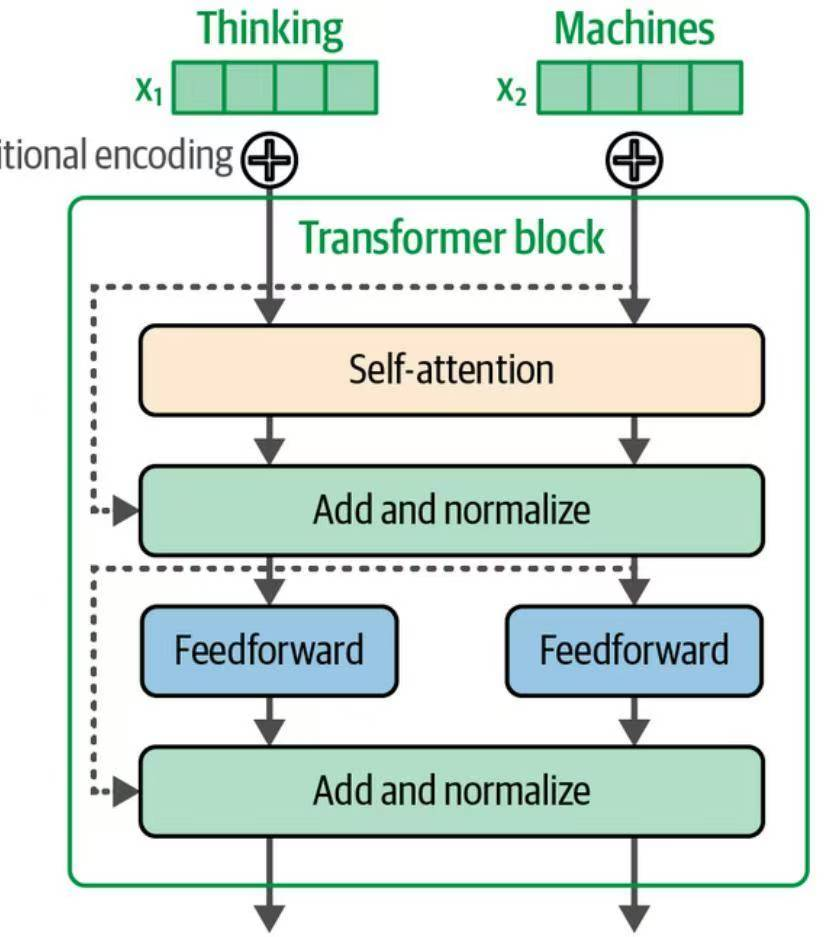

最新的Transformer模型仍然保留了主要组件，但做了一些调整。

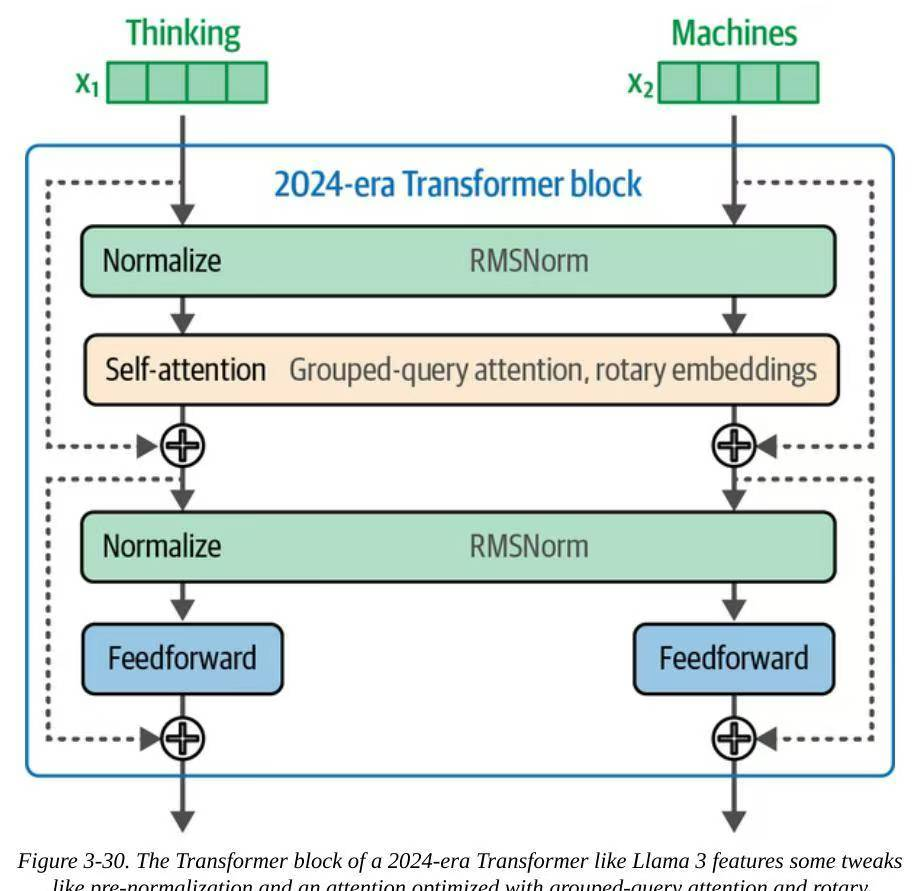

我们在这个版本的Transformer块中看到的一个不同之处在于，规范化发生在注意力和前馈层之前。据报道，这可以减少所需的训练时间。这里规范化的另一个改进是使用RMSNorm，它比原始Transformer中使用的LayerNorm更简单、更高效。最后，与原版Transformer的ReLU激活函数不同，SwiGLU等现在更为常见。

## Positional Embedding(RoPE)

位置嵌入从最初的Transformer开始就是一个关键部分。它们使模型能够跟踪序列/句子中记号/单词的顺序，这是语言中不可或缺的信息源。

例如，将第一个标记为位置1，第二个标记为位置2……等等。这些可以是静态方法(其中位置向量是使用几何函数生成的)或学习方法(其中模型训练在学习过程中为它们分配值)。当我们扩大模型时，这些方法会带来一些挑战，这需要我们找到提高其效率的方法。

例如，有效训练具有大上下文的模型的一个挑战是，训练集中的许多文档比该上下文短得多。如果将整个上下文(比如4K上下文)分配给一个10个单词的短句子，效率会很低。

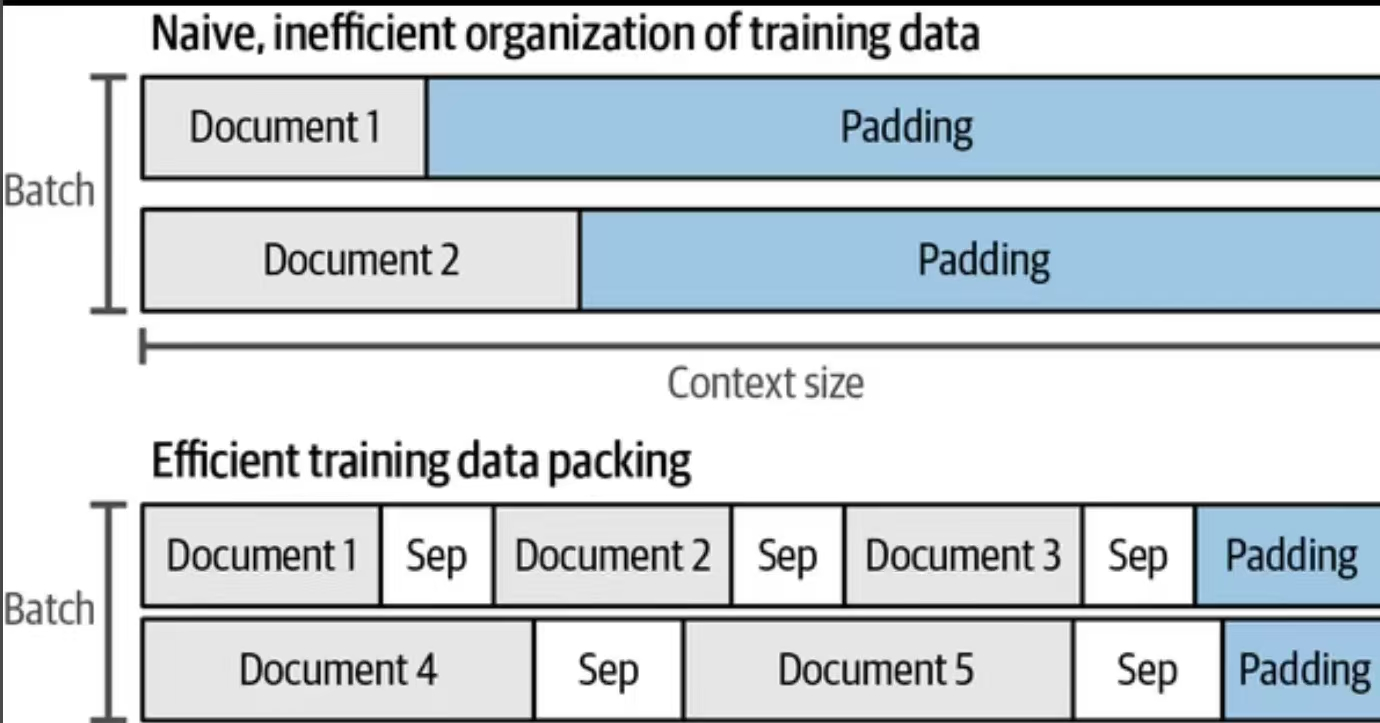

与前向传递开始时添加的静态绝对嵌入不同，旋转嵌入是一种以捕获绝对和相对token位置信息的方式对位置信息进行编码的方法。它基于向量在其嵌入空间中旋转的思想。在前向传递中，在注意步骤中添加它们。

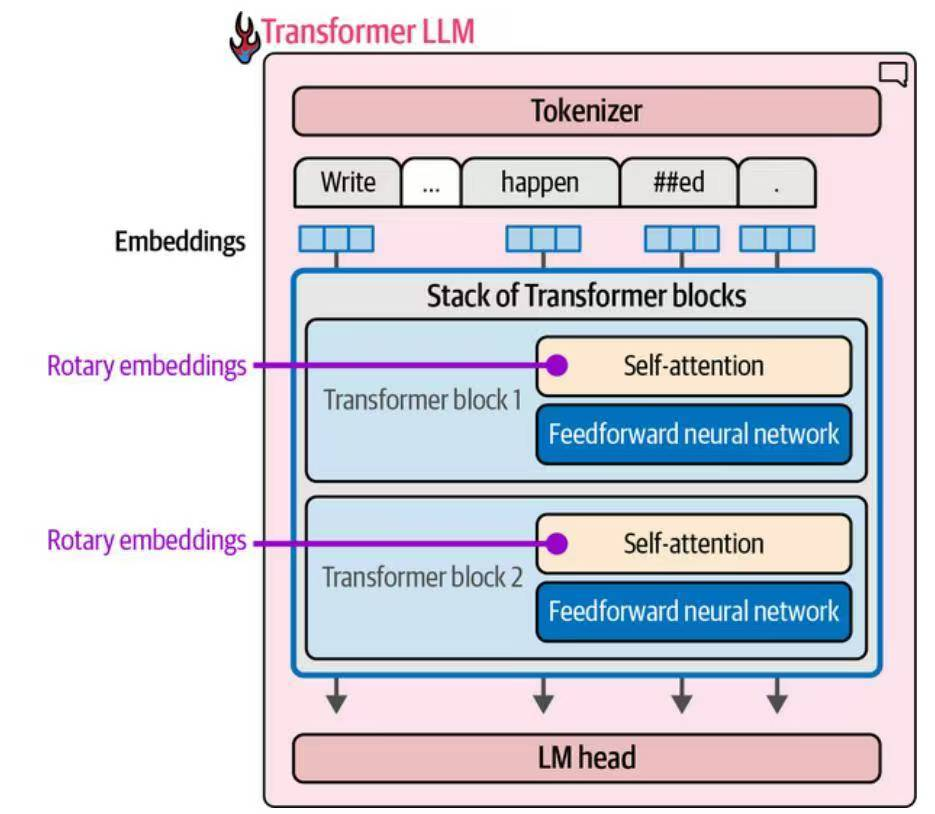

在注意过程中，位置信息被专门混合到查询和键矩阵中，然后我们将它们相乘进行相关性评分。

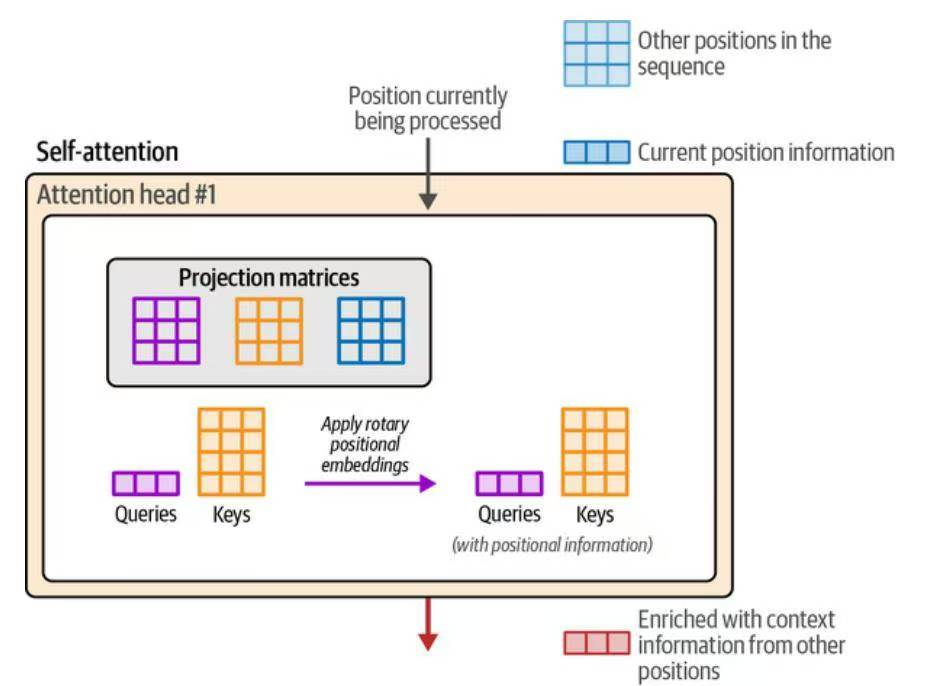

# Summmary

- Transformer LLM每次生成一个令牌。
- 该输出令牌被附加到提示符中，然后这个更新后的提示符再次呈现给模型，进行另一次向前传递以生成下一个令牌。
- Transformer LLM的三个主要组件是标记器、Transformer块堆栈和语言建模头。
- 标记器包含模型的标记词汇表。模型具有与这些标记相关联的标记嵌入。将文本分解成token，然后使用这些token的嵌入是token生成过程的第一步。
- 前向传递一次流过所有阶段，一个接一个。
- 在接近过程结束时，LM头对下一个可能的令牌的概率进行评分。解码策略告知要选择哪个实际令牌作为此生成步骤的输出(有时它是最有可能的下一个令牌，但并非总是如此)。
- Transformer出色的一个原因是其并行处理令牌的能力。每个输入令牌都流入它们各自的轨道或处理流。流的数量是模型的“上下文大小”，这代表了模型可以操作的令牌的最大数量。
- 因为Transformer llm循环一次生成一个令牌的文本，所以缓存每一步的处理结果是一个好主意，这样我们就不会重复处理工作(这些结果被存储为层内的各种矩阵)。
- 大部分的处理都发生在Transformer块内。它们由两个组件组成。其中一个是前馈神经网络，它能够存储信息，并根据训练过的数据进行预测和插值。
- Transformer块的第二个主要组件是注意层。注意层结合了上下文信息，使模型能够更好地捕捉语言的细微差别。
- 注意力发生在两个主要步骤中:(1)对相关性进行评分，(2)对信息进行组合。
- Transformer注意层并行地进行多个注意操作，每个操作都发生在一个注意头内，它们的输出被聚合起来，构成注意层的输出。
- 可以通过在所有头或头组(分组查询注意)之间共享键和值矩阵来加速注意。
- 像Flash Attention这样的方法通过优化操作在GPU的不同内存系统上的完成方式来加速注意力计算。 

【Transformer 模型详解 - CSDN App】https://blog.csdn.net/benzhujie1245com/article/details/117173090?sharetype=blog&shareId=117173090&sharerefer=APP&sharesource=m0_56270374&sharefrom=link